# Comprendre Scikit-Learn

In [0]:
import os
"to load assets on the server (if it was not already done)"
if not os.path.exists("assets_ml"):
    !git clone https://github.com/vincentvigon/assets_ml
else:
    print("assets already here")

data already here


In [0]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.pipeline

import warnings
from IPython.display import Image
import os


plt.style.use("default")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=500)
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


"fonction utilitaire"
def load_all_data():
    
    df0 = pd.read_csv("assets_ml/dataframe/oecd_bli_2015.csv", thousands=',')
    "we keep only some lines "
    df1 = df0[df0["INEQUALITY"]=="TOT"]
    "and make a pivot table to  indicators and their values by country"
    df2 = df1.pivot(index="Country", columns="Indicator", values="Value")
    df_gdp = pd.read_csv("assets_ml/dataframe/gdp_per_capita.csv", thousands=',', delimiter='\t',
                                 encoding='latin1', na_values="n/a")
    df_gdp.rename(columns={"2015": "GDP per capita"}, inplace=True)
    df_gdp.set_index("Country", inplace=True)
    df_full = pd.merge(left=df_gdp[["GDP per capita"]], right=df2, left_index=True, right_index=True)
    df_full.sort_values(by="GDP per capita", inplace=True)

    "we remove some countries"
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    " to substract list, we transform them into set. This an fast technic (avoiding a double loop) "
    keep_indices = list(set(range(36)) - set(remove_indices))
    df_sample = df_full[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
    df_missing = df_full[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]
    
    return df_full,df_sample,df_missing,df_gdp


        
assert os.path.exists("assets_ml"), "please import assets via git"

## Charger les données 

L'argent rend-il heureux? On télécharge une base de donnée de l'OECD (Organisation for Economic Co-operation and Development) dans laquel on trouve notamment le [Better Life Index](https://stats.oecd.org/index.aspx?DataSetCode=BLI) de  et une base de donnée relative au PIB: [GDP per capita]( http://goo.gl/j1MSKe) de IMF (International Monetary Found).

### Les données "Life satisfaction" 

D'après le site de [OCDE](http://www.oecdbetterlifeindex.org/topics/life-satisfaction/): 

<< Life satisfaction measures how people evaluate their life as a whole rather than their current feelings. When asked to rate their general satisfaction with life on a scale from 0 to 10, people on average across the OECD gave it a 6.5. Life satisfaction is not evenly shared across the OECD however. Some countries – Greece, Hungary, Portugal and Turkey – have a relatively low level of overall life satisfaction, with average scores of 5.5 or less. At the other end of the scale, scores reach 7.5 in Denmark, Finland, Iceland, Norway and Switzerland >>


In [0]:
df0 = pd.read_csv("assets_ml/dataframe/oecd_bli_2015.csv", thousands=',')
df0.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


***A vous:*** $(1\heartsuit)$ A quoi sert l'option `thousands=','`?

On voit ci-dessous que pour chaque pays, il a beaucoup de lignes.

***Remarque:*** Les bases de donnée `no-sql` qui ont des structure arborescentes sont été mieux adaptées à ce type de donnée.  

In [0]:
df0[df0["LOCATION"]=="BEL"].head(10)

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
39,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,MN,Men,PC,Percentage,0,units,NaN,NaN,2.0,E,Estimated value
75,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,WMN,Women,PC,Percentage,0,units,NaN,NaN,2.0,E,Estimated value
111,BEL,Belgium,HO_HISH,Housing expenditure,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,21.0,NaN,NaN
148,BEL,Belgium,HO_HISH,Housing expenditure,L,Value,MN,Men,PC,Percentage,0,units,NaN,NaN,21.0,E,Estimated value
184,BEL,Belgium,HO_HISH,Housing expenditure,L,Value,WMN,Women,PC,Percentage,0,units,NaN,NaN,21.0,E,Estimated value
220,BEL,Belgium,HO_NUMR,Rooms per person,L,Value,TOT,Total,RATIO,Ratio,0,units,NaN,NaN,2.2,NaN,NaN
257,BEL,Belgium,HO_NUMR,Rooms per person,L,Value,MN,Men,RATIO,Ratio,0,units,NaN,NaN,2.2,E,Estimated value
293,BEL,Belgium,HO_NUMR,Rooms per person,L,Value,WMN,Women,RATIO,Ratio,0,units,NaN,NaN,2.2,E,Estimated value
329,BEL,Belgium,IW_HADI,Household net adjusted disposable income,L,Value,TOT,Total,USD,US Dollar,0,units,NaN,NaN,28307.0,NaN,NaN


Observons les différents indicateurs disponibles.

***A vous:*** Tous les indicateurs sont-ils disponibles pour tous les pays? Justifiez ($2\heartsuit$).

In [0]:
"let's see the the different 'indicator' "
df0["Indicator"].value_counts()

Self-reported health                         185
Long-term unemployment rate                  185
Personal earnings                            185
Voter turnout                                185
Student skills                               185
Employment rate                              185
Household net adjusted disposable income     183
Life satisfaction                            179
Quality of support network                   167
Job security                                 111
Life expectancy                              111
Homicide rate                                111
Water quality                                111
Employees working very long hours            111
Educational attainment                       111
Years in education                           111
Assault rate                                 111
Time devoted to leisure and personal care    111
Household net financial wealth               109
Consultation on rule-making                  109
Rooms per person    

In [0]:
"we keep only some lines "
df1 = df0[df0["INEQUALITY"]=="TOT"]
"and make a pivot table to  indicators and their values by country"
df2 = df1.pivot(index="Country", columns="Indicator", values="Value")
df2.head()

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,20.0,4.8,82.1,7.3,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,21.0,3.9,81.0,6.9,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,21.0,5.0,80.5,6.9,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,21.0,6.4,81.5,7.3,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2


In [0]:
df2["Life satisfaction"].sort_values(ascending=False) #by default inplace=False, so a original df do not change

Country
Switzerland        7.5
Denmark            7.5
Iceland            7.5
Norway             7.4
Finland            7.4
Israel             7.4
Australia          7.3
Canada             7.3
Netherlands        7.3
New Zealand        7.3
United States      7.2
Sweden             7.2
Germany            7.0
Ireland            7.0
Brazil             7.0
Austria            6.9
Luxembourg         6.9
Belgium            6.9
United Kingdom     6.8
Mexico             6.7
Chile              6.7
OECD - Total       6.6
Czech Republic     6.5
France             6.5
Spain              6.5
Slovak Republic    6.1
Russia             6.0
Italy              6.0
Japan              5.9
Poland             5.8
Korea              5.8
Slovenia           5.7
Estonia            5.6
Turkey             5.6
Portugal           5.1
Hungary            4.9
Greece             4.8
Name: Life satisfaction, dtype: float64

### Les données PIB

Citons Wikipedia:

<< Per capita GDP is a measure of the total output of a country that takes the gross domestic product (GDP=produit intérieur brut) and divides it by the number of people in that country. The per capita GDP is especially useful when comparing one country to another, because it shows the relative performance of the countries >>. 



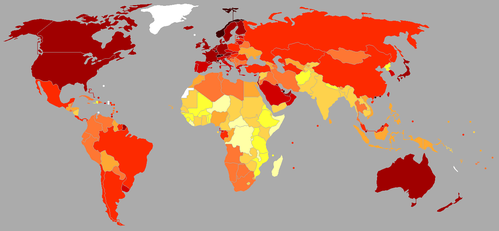

In [0]:
Image("assets_ml/img/GDP.png")

In [0]:
df_gdp = pd.read_csv("assets_ml/dataframe/gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
df_gdp.rename(columns={"2015": "GDP per capita"}, inplace=True)
df_gdp.set_index("Country", inplace=True)
df_gdp.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


In [0]:
"our final dataframe"
df_full = pd.merge(left=df_gdp[["GDP per capita"]], right=df2, left_index=True, right_index=True)
df_full.sort_values(by="GDP per capita", inplace=True)
df_full.head(10)

,GDP per capita,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,,
Brazil,8669.998,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Mexico,9009.280,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,21.0,4.9,74.6,6.7,0.08,16193.0,77.0,1.0,66.0,417.0,13.89,63.0,67.0,14.4
Russia,9054.914,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,11.0,4.0,70.2,6.0,1.70,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0
Turkey,9437.372,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,21.0,8.1,74.6,5.6,2.37,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4
Hungary,12239.894,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,20.0,5.7,75.2,4.9,5.10,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6
Poland,12495.334,33.0,1.4,10.8,3.2,90.0,7.41,60.0,0.9,17852.0,10919.0,21.0,7.3,76.9,5.8,3.77,22655.0,91.0,1.1,58.0,521.0,14.20,55.0,79.0,18.4
Chile,13340.905,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,18.0,4.4,78.9,6.7,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Slovak Republic,15991.736,13.0,3.0,6.6,0.6,92.0,7.02,60.0,1.2,17503.0,8663.0,26.0,5.5,76.2,6.1,9.46,20307.0,90.0,1.1,66.0,472.0,14.99,59.0,81.0,16.3
Czech Republic,17256.918,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,26.0,4.1,78.2,6.5,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1


In [0]:
df_full.tail(10)

,GDP per capita,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,,
United Kingdom,43770.688,13.0,1.9,11.5,0.2,78.0,12.70,71.0,0.3,27029.0,60778.0,23.0,5.2,81.0,6.8,2.77,41192.0,91.0,1.9,74.0,502.0,14.83,66.0,88.0,16.4
Sweden,49866.266,10.0,5.1,10.9,0.0,88.0,1.13,74.0,0.7,29185.0,60328.0,20.0,6.5,81.8,7.2,1.37,40818.0,92.0,1.7,81.0,482.0,15.11,86.0,95.0,19.3
Iceland,50854.583,18.0,2.7,5.1,0.4,71.0,12.25,82.0,0.3,23965.0,43045.0,24.0,4.1,83.0,7.5,1.18,55716.0,96.0,1.5,77.0,484.0,14.61,81.0,97.0,19.8
Australia,50961.865,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,20.0,4.8,82.1,7.3,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Ireland,51350.744,13.0,2.6,9.0,0.2,75.0,4.20,60.0,0.8,23917.0,31580.0,19.0,5.9,81.0,7.0,8.39,49506.0,96.0,2.1,82.0,516.0,15.19,70.0,80.0,17.6
Denmark,52114.165,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,24.0,5.6,80.1,7.5,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
United States,55805.204,18.0,1.5,8.3,0.1,89.0,11.30,67.0,5.2,41355.0,145769.0,18.0,5.9,78.7,7.2,1.91,56340.0,90.0,2.4,88.0,492.0,14.27,68.0,85.0,17.2
Norway,74822.106,16.0,3.3,8.1,0.3,82.0,2.82,75.0,0.6,33492.0,8797.0,17.0,3.1,81.5,7.4,0.32,50282.0,94.0,2.0,76.0,496.0,15.56,78.0,94.0,17.9
Switzerland,80675.308,20.0,4.2,8.4,0.0,86.0,6.72,80.0,0.5,33491.0,108823.0,22.0,3.0,82.8,7.5,1.46,54236.0,96.0,1.8,81.0,518.0,14.98,49.0,96.0,17.3


### Séparation des données

On verra plus tard qu'on sépare souvent les données en `train` et `test`. Mais ici c'est uniquement pour des raisons pédagofiques que l'on met de côté certain pays.

In [0]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
" to substract list, we transform them into set. This an fast technic (avoiding a double loop) "
keep_indices = list(set(range(36)) - set(remove_indices))

df_sample = df_full[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
df_missing = df_full[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

print("missing countries:\n",df_missing.index.values)

missing countries:
 ['Brazil' 'Mexico' 'Chile' 'Czech Republic' 'Norway' 'Switzerland' 'Luxembourg']


### checkpoint $\checkmark$

On crée maintenant une fonction `load_all_data()` qui reprend toutes les étapes précédentes pour la création des données. Cette fonction a été reportée dans la top-cell pour pouvoir faire des `%reset` réguliers. 

## Création du model $\hookleftarrow$

On repartir de zéro: faites un run sur la top-cell

In [0]:
df_full,df_sample,df_missing,df_gdp=load_all_data()

x_sample = df_sample["GDP per capita"].values
"ajout d'une colonne de 1"
X_sample_ext= np.stack([np.ones_like(x_sample),x_sample],axis=1) 
y_sample = df_sample["Life satisfaction"].values
print("x_sample.shape:",x_sample.shape)
print("X_sample_ext.shape",X_sample_ext.shape)
print("y_sample.shape",y_sample.shape)

"some very simple test data: points regularly spaced on a given interval"
xlim=60000
x_test=np.linspace(0, xlim, 1000)

x_sample.shape: (29,)
X_sample_ext.shape (29, 2)
y_sample.shape (29,)


In [0]:
"we save some data"
df_sample.to_csv('assets_ml/img/df_sample.csv')
df_missing.to_csv('assets_ml/img/df_missing.csv')
df_full.to_csv('assets_ml/img/df_full.csv')

### Observons les données

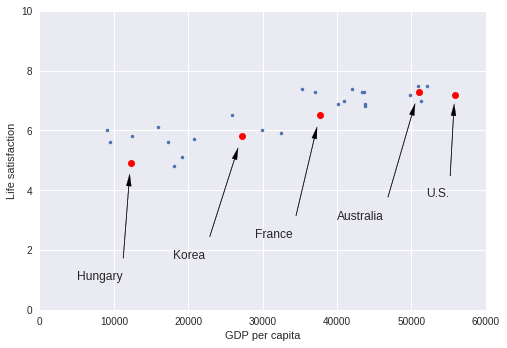

In [0]:
plt.plot(x_sample,y_sample,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)

#variante en utilisant le plot de pandas
#df_sample.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,4))


position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = df_sample.loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text, arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")

On voit une tendance: la `life satisfaction` semble croitre 'linéairement' en fonction de la `GDP per capita`. 


Dans toute la suite on notera:
* $X$=GDP per capita
* $Y$=Life statisfaction

On suppose que nos données suivent le modèle suivant:
$$
\hat Y = w_0 + w_1 X 
$$

***Vocabulaire:*** Le coefficient $w_0$ est appelé biais = intercept = terme constant.  


### Ajustement du modèle

In [0]:
model_lin_sample = sklearn.linear_model.LinearRegression(fit_intercept=False)

model_lin_sample.fit(X_sample_ext, y_sample)
w0, w1=model_lin_sample.coef_[0],model_lin_sample.coef_[1]

print("w0:%.2f"%w0,", w1:%.2E"%w1)

w0:4.85 , w1:4.91E-05


Attention, par défaut, `fit_intercept=True`,
mais dans ce cas il ne faut pas rajouter une colonne de 1. sklearn le fait tout seul. Dans ce cas, on récupère w0 et w1 comme ceci:

     w0 , w1= model_lin_sample.intercept_ , lin1.coef_[0]

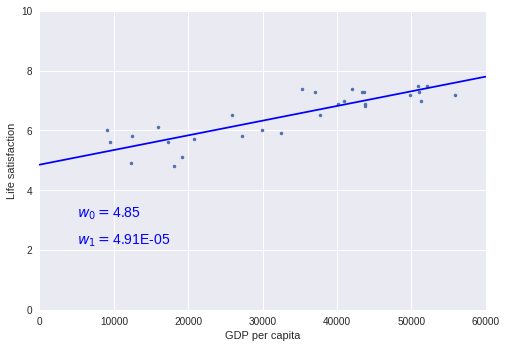

In [0]:
plt.plot(x_sample,y_sample,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)

plt.plot(x_test, w0 + w1*x_test, "b")

plt.text(5000, 3.1, r"$w_0=$"+"%.2f"%w0, fontsize=14, color="b")
plt.text(5000, 2.2, r"$w_1=$"+"%.2E"%w1, fontsize=14, color="b");

Maintenant ce modèle liénaire est le plus proche possible des donnée (au sens des moindres carré). 

### Prédiction

On aimerait savoir si les Chipriotes sont heureux. Mais la réponse ne se trouve pas dans les données de l'OECD.  Par contre on connait le PIB de Chypre: $22\,587\$$


In [0]:
cyprus_gdp = df_gdp.loc["Cyprus"]["GDP per capita"]
print("cyprus gdp per capita:",cyprus_gdp)
cyprus_life_hat = model_lin_sample.predict([[1,cyprus_gdp]])
print("prediction of cyprus life satisfaction:",cyprus_life_hat)

cyprus gdp per capita: 22587.49
prediction of cyprus life satisfaction: [5.96]


***A vous:*** Retrouvez $(1\heartsuit)$ la valeur prédite sans utiliser la méthode `.predict()` mais en utilisant direcement `w0` et `w1`.

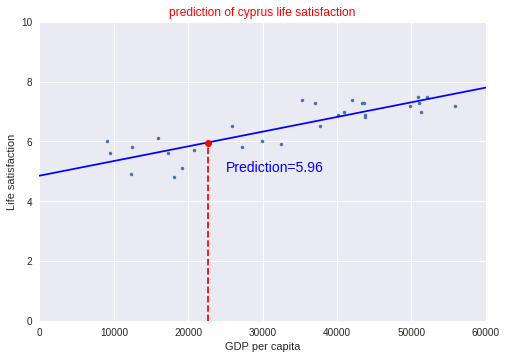

In [0]:
plt.plot(x_sample,y_sample,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)

a=np.linspace(0, xlim, 1000)
plt.plot(a, w0 + w1*a, "b")

plt.title("prediction of cyprus life satisfaction",color="r")
plt.plot([cyprus_gdp, cyprus_gdp], [0, cyprus_life_hat], "r--")
plt.text(25000, 5.0, "Prediction=%.2f"%cyprus_life_hat, fontsize=14, color="b")
plt.plot(cyprus_gdp, cyprus_life_hat, "ro");

***A vous:***  Calculez $(2\heartsuit)$ la prédiction donnerait l'algo des 3 plus proches voisins (instance-based). Il faut simplement répérer les 4 pays les plus proches de Chipre et moyenner leur `life_satisfaction`. Aide: utilisez `sort_values()`.

### Résumé

En résumé nous avons:

*  observer les données.
* Sélectionner le modèle.
* Entrainer (=ajuster=fiter) le modèle 
* Utiliser le modèle pour faire une prédiction

Ce sont les étapes classique d'un projet de machine-learning

##  Données d'entrainement non représentatives $\hookleftarrow$

Pour qu'un modèle se généralise bien, il faut que les données d'entrainement soient représentatives de l'ensemble des données. Etait-ce le cas? 

In [0]:
df_full,df_sample,df_missing,df_gdp=load_all_data()

"numpy extraction"
x_sample = df_sample["GDP per capita"].values
X_sample_ext= np.stack([np.ones_like(x_sample),x_sample],axis=1) 
y_sample = df_sample["Life satisfaction"].values

"numpy extraction"
x_full = df_full["GDP per capita"].values
X_full_ext = np.stack([np.ones_like(x_full),x_full],axis=1) 
y_full = df_full["Life satisfaction"].values

"some very simple test data: points regularly spaced on a given interval"
xlim=110000
x_test=np.linspace(0, xlim, 1000)

Rappelons que nous avions enlever certains pays:

In [0]:
df_missing

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


In [0]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

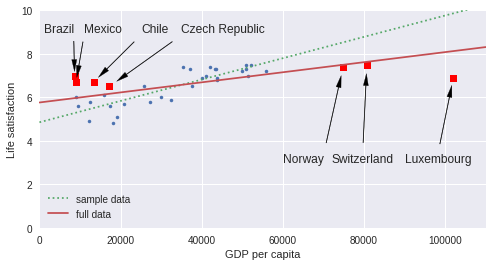

In [0]:
plt.figure(figsize=(8,4))
plt.plot(x_sample,y_sample,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = df_missing.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")
    

def fit_and_plot_lin_model(X,y):    
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, y)
    w0, w1=model.coef_[0],model.coef_[1]
    return w0,w1
    
    
w0_sample,w1_sample=fit_and_plot_lin_model(X_sample_ext,y_sample)
w0_full,w1_full=fit_and_plot_lin_model(X_full_ext,y_full)

plt.plot(x_test, w0_sample + w1_sample*x_test,":",label="sample data")
plt.plot(x_test, w0_full + w1_full*x_test,label="full data")
plt.legend(loc=3);



## Sous et sur-ajustement $\hookleftarrow$ 

Notre modèle précédent était sous-ajusté. On va le complexifier pour qu'il colle mieux aux données. 


In [0]:
df_full,df_sample,df_missing,df_gdp=load_all_data()

"numpy extraction"
x = df_full["GDP per capita"].values
"cette fois-ci, on n'ajoute pas la colonne de 1"
X = x[:,np.newaxis] 
y = df_full["Life satisfaction"].values

"some very simple test data: points regularly spaced"
xlim=110000
x_test=np.linspace(0, xlim, 1000)

### Un bon modèle polynomial

On va supposer que nos données suivent un modèle polynomiale de degré 5: 
$$
\hat Y = f_w(X) = w_0 +w_1 X+ w_2 X^2 + ... + w_{5} X^{5}
$$

On ajuste ce modèles, c'est a dire, on trouve les coefficients $w$ qui minimisent 
$$
\sum_{i \in train} dist\big(Y_i,f_w(X_i)\big)
$$


X_poly.shape: (36, 5)
[[8.67e+03 7.52e+07 6.52e+11 5.65e+15 4.90e+19]
 [9.01e+03 8.12e+07 7.31e+11 6.59e+15 5.94e+19]
 [9.05e+03 8.20e+07 7.42e+11 6.72e+15 6.09e+19]
 [9.44e+03 8.91e+07 8.41e+11 7.93e+15 7.49e+19]
 [1.22e+04 1.50e+08 1.83e+12 2.24e+16 2.75e+20]
 [1.25e+04 1.56e+08 1.95e+12 2.44e+16 3.05e+20]
 [1.33e+04 1.78e+08 2.37e+12 3.17e+16 4.23e+20]]
X_poly_scaled.shape: (36, 5)
[[-1.25 -0.79 -0.52 -0.38 -0.3 ]
 [-1.24 -0.79 -0.52 -0.38 -0.3 ]
 [-1.23 -0.79 -0.52 -0.38 -0.3 ]
 [-1.22 -0.79 -0.52 -0.38 -0.3 ]
 [-1.09 -0.76 -0.51 -0.37 -0.3 ]
 [-1.07 -0.75 -0.51 -0.37 -0.3 ]
 [-1.03 -0.74 -0.51 -0.37 -0.3 ]]


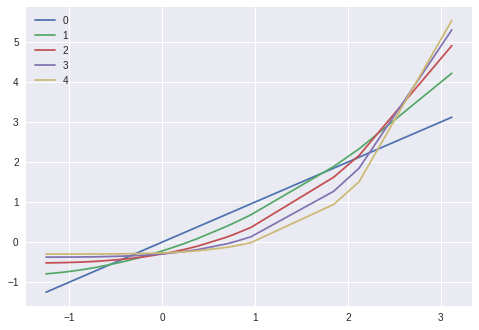

In [0]:
from sklearn import preprocessing
np.set_printoptions(precision=2)

degree=5
poly = preprocessing.PolynomialFeatures(degree=degree, include_bias=False)
X_poly=poly.fit_transform(X)
print("X_poly.shape:",X_poly.shape)
print(X_poly[:7,:7])

scaler = preprocessing.StandardScaler()
X_poly_scaled=scaler.fit_transform(X_poly)
print("X_poly_scaled.shape:",X_poly_scaled.shape)
print(X_poly_scaled[:7,:7])

for i in range(degree):
    plt.plot(X_poly_scaled[:,0],X_poly_scaled[:,i],label=str(i))
plt.legend();

In [0]:
# this time we ask to the model to add the intercept
model_poly = sklearn.linear_model.LinearRegression() #= .LinearRegression(fit_intercept=True)
model_poly.fit(X_poly_scaled, y)

print("coef_:\n",model_poly.coef_)
print("intercept_:%.2f"%model_poly.intercept_)

coef_:
 [ -14.07   69.31 -137.79  126.66  -43.99]
intercept_:6.58


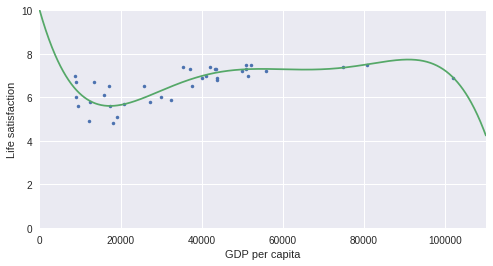

In [0]:
plt.figure(figsize=(8,4))
plt.plot(x,y,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)


X_test_poly=poly.transform(x_test[:,np.newaxis])
X_test_poly_scaled=scaler.transform(X_test_poly)
y_test_hat = model_poly.predict(X_test_poly_scaled)
plt.plot(x_test, y_test_hat);

***A vous:*** Reproduisez $(3\heartsuit)$ cette courbe polynomiale à partir de `.coef_` et `.intercept_` (sans utiliser .predict). 

### Un modèle sur-ajusté

On choisi maintenant de modéliser les donnée avec un polynome de très grand degré. 

$$
\hat Y = f_w(X) = w_0 +w_1 X+ w_2 X^2 + ... + w_{20} X^{20}
$$

Par ailleurs, informatiquement, on emboite les traitements à l'aide d'un `pipeline` de `sklearn`. Plus d'explications viennent plus loin.  

estimated coef:
 [ 2.77e+05 -7.41e+06  1.14e+08 -1.19e+09  8.77e+09 -4.67e+10  1.81e+11 -5.09e+11  1.00e+12 -1.28e+12  7.80e+11  3.07e+11 -7.93e+11  9.43e+10  5.86e+11 -2.07e+11 -3.90e+11  3.13e+11 -2.28e+10 -2.70e+10]
estimated intercept:
 6.583299411735984


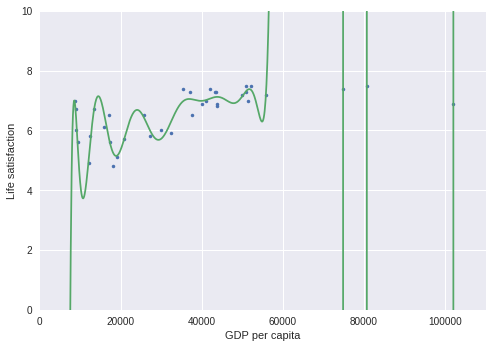

In [0]:
plt.plot(x,y,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)


poly = sklearn.preprocessing.PolynomialFeatures(degree=20, include_bias=False)
scaler = sklearn.preprocessing.StandardScaler()
lin_reg2 = sklearn.linear_model.LinearRegression()
pipeline_reg = sklearn.pipeline.Pipeline([('poly', poly), ('scal', scaler),('lin',lin_reg2)])

# this call fit_transform() of the two first objects: 'poly' and 'scal',
# and   the method .fit() for the third one: 'lin'
pipeline_reg.fit(X, y) 
print("estimated coef:\n",pipeline_reg.named_steps['lin'].coef_)
print("estimated intercept:\n",pipeline_reg.named_steps['lin'].intercept_)

# this call transform() of the two first objects: 'poly' and 'scal',
# and   the method .predict() for the third one: 'lin'
y_test_hat = pipeline_reg.predict(x_test[:,np.newaxis])

plt.plot(x_test,y_test_hat);

### Contraindre un modèle par la régularisation

L'overfitting vient quand le modèle est trop complexe. Pour limiter cela les solutions sont: 

* Sélectionner un modèle avec moins de paramétre: ex: un modèle linéaire plutôt qu'un modèle polynomial de haut degré. MAIS: on risque de tomber dans le sous-ajustement. 
* Supprimer des descripteurs inutile. MAIS pas facile à savoir à l'avance. 
* Augmenter le nombre de données train. MAIS en général on utilise toutes les données dont on dispose. 
* Bien nettoyer ses données. MAIS on l'a déjà fait car on est sérieux. 


Il existe une solution supplémentaire: la régularisation: On garde un modèle avec beaucoup de paramètre, mais on oblige les paramètres à être assez petit. Pour cela on va trouver le $w$ qui va minimiser 

$$
\sum_{i \in train} dist\big(Y_i,f_w(X_i)\big) + \alpha \|w\|
$$

$\alpha$ est un coef positif, et le plus souvent on chosi l'une des deux normes suivantes:

* $\|w\|= |w_1| + ...+ |w_{20}| $. On parle de pénalité lasso. 
* $\|w\|= (w_1)^2 + ...+ (w_{20})^2 $. On parle de pénalité rigde.

Avec ce procéde de pénalisation, on laisse beaucoup de degré de liberté au modèle, mais, lors de l'apprentissage, on lui demande de trouver le bon équilibre entre le bon ajustement aux données train, et la simplicité. Cela aide à la généralisation. 
  





estimated coef:
 [ 0.43  0.55  0.09 -0.2  -0.28 -0.26 -0.2  -0.14 -0.09 -0.04 -0.01  0.02  0.03  0.05  0.06  0.07  0.07  0.07  0.08  0.08]
estimated intercept:
 6.583333333333333


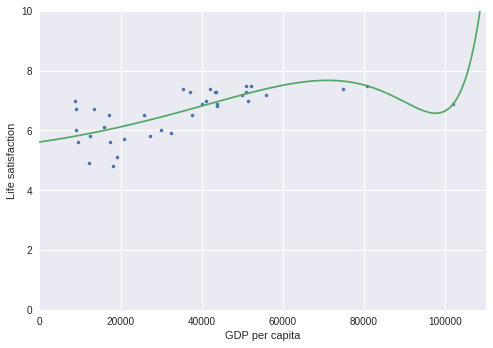

In [0]:
plt.plot(x,y,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)

from sklearn import preprocessing
from sklearn import pipeline


poly = preprocessing.PolynomialFeatures(degree=20, include_bias=False)
scaler = preprocessing.StandardScaler()
ridge = sklearn.linear_model.Ridge(alpha=0.5)
pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler),('lin',ridge)])

pipeline_reg.fit(X, y) 
print("estimated coef:\n",pipeline_reg.named_steps['lin'].coef_)
print("estimated intercept:\n",pipeline_reg.named_steps['lin'].intercept_)

y_test_hat = pipeline_reg.predict(x_test[:,np.newaxis])

plt.plot(x_test,y_test_hat);

## Le design de Scikit-Learn

L'API de `sklearn` est remarquablement bien conçue.  Voici un extrait du livre d'Aurélien Géron qui explique le principe du design.


### Consistence. 

Tous les objets partage la même interface simple. Voici les différents types d'objets:

* ***Estimateurs.***  Se sont les objets qui estiment des paramètre à partir des données. Ex:

        StandardScaler, LinearRegression, Ridge 

L'estimation est lancée lors de l'appelle de la méthode `fit()` qui prend comme paramètre `X` pour les algos non-supervisées ou bien `X,Y` pour les alogs supervisés.   

Tous les autres paramètres sont considérés comme des hyperparamètres (tel que `degree` ou `alpha`) et sont des variables d'instance (self.degree ou self.alph). La plupart du temps, ces variables d'instances peuvent être assignée via le constructeur de l'objet. 


* ***Transformeurs.***  Ils peuvent aussi transformer les données. Ex:

        StandardScaler, PolynomialFeatures

La transformation est faite par la méthode `transform()` qui prend les données `X` comme paramètre. Elle retourne les données transformées. Le plus souvent, cette transformation dépend de paramètre appris sur le jeu de donnée (ex: centrer-réduire nécéssite de caculer la moyenne et l'écart type). Ainsi les transformeur ont aussi une méthode `fit()`. 

Ils disposent aussi d'une méthode `fit_transform()` qui est l'équivalent de l'appel de `fit()` puis de l'appel de `transform()`. 


* ***Prédicteur.***  Ils font des prédictions. Ex:

        LinearRegression, Ridge 

Un prédicteur a une méthode `predict(X)` qui prend des données `X` en entrée et retourne des prédictions `hat Y`. 

Certain des prédicteurs ont aussi un méthode `predict_proba(X)` qui donnée la fiabilité des prédictions. 

Certain des prédicteurs ont aussi une méthode `score()` qui meture la qualité des prédictions (le score va toujours dans le sens inverse de la `loss`). Dans les algos supervisés, `score(X,Y)` mesurera une sorte d'inverse d'une distance entre `predict(X)` et `Y`. 


### Inspection

Tous les hyperparamètres des estimateurs sont accessibles via des variables d'instances, ex:

        ridge.alpha, polynomialFeatures.degree

Tous les paramètres appris sont aussi accessible via des variables d'instances qui ont un underscore à la fin, ex:

       ridge.coef_, ridge.intercept_ 


### Non prolifération des classes

Les données sont représentée pas des tableaux numpy ou des matrices creuses SciPy (pas de classe maison). 


### Des valeurs par défaut sensées. 

Scikit-Learn propose de bonnes valeurs par défaut pour la plupart des paramètres. On peut donc démarrer vite.  


### Composition.

Les "briques" de scikit-learn sont réutilisés au maximum.


### Typage 'canard'

« Si je vois un oiseau qui vole comme un canard, cancane comme un canard, et nage comme un canard, alors j'appelle cet oiseau un canard » [James Whitcomb Riley]

sklearn utilise le typage canard (duck typing): pas d'héritages, pas de typage statique: pour qu'un objet soit accepté comme estimateur, il suffit qu'il ait une méthode `fit()`

  

## Reproduisons sklearn $\hookleftarrow$

Le fait de recoder un bout de la librairie va nous permettre de mieux comprendre comme elle fonctionne, et éventuellement, on pourra dans le futur remplacer certaine briques par des briques personnalisées. Nous ne prétendons pas faire mieux! 

In [0]:
df_full,df_sample,df_missing,df_gdp=load_all_data()

"numpy extraction"
x = df_full["GDP per capita"].values
X = x[:,np.newaxis] 
y = df_full["Life satisfaction"].values

"some very simple test data: points regularly spaced"
xlim=110000
x_test=np.linspace(0, xlim, 1000)

### Deux transformers

Reproduisons le `PolynomialFeatures` de `sklearn`. Remarquons que la méthode `fit()` ne fait rien. 

Puis reproduisons le `StandardScaler`. Cette fois-ci `fit()` calcule bien quelque chose sur les données. 


In [0]:
class MyPolynomialFeatures:

    def __init__(self,degree): #Todo: add 'include_bias' (with False as default)
        self.degree=degree
    
    
    def transform(self,X):
        assert len(X.shape)==2, "X must be a matrix"
        assert X.shape[1]==1, "X must be a column matrix" 
        #Todo: generalize when X has several columns. So we have to add  products between columns
        
        res=[] # pas très malin l'emploi d'une liste ici.
        for i in range(1,self.degree+1):
            res.append(X[:,0]**i)
        
        res_np=np.stack(res,axis=1)
        return res_np
        
    def fit(self,X):
        pass
    
    def fit_transform(self,X):
        return self.transform(X)
    

***A vous:*** Effectuez $(2\heartsuit+3\heartsuit)$ les deux `todo` dans le code de `MyPolynomialFeatures`. Testez-les. 

In [0]:
a=np.arange(0,11,1)
A=a[:,np.newaxis]
A_ext=MyPolynomialFeatures(3).fit_transform(A)
print(A_ext)

[[   0    0    0]
 [   1    1    1]
 [   2    4    8]
 [   3    9   27]
 [   4   16   64]
 [   5   25  125]
 [   6   36  216]
 [   7   49  343]
 [   8   64  512]
 [   9   81  729]
 [  10  100 1000]]


In [0]:
class MyStandardScaler:
    
    def __init__(self): 
        pass
                
    def fit(self,X):
        self.mean_=np.mean(X,axis=0)
        self.std_=np.std(X,axis=0)
                
    
    def transform(self,X):
        assert len(X.shape)==2, "X must be a matrix"
        
        "res[i,j]=(X[i,j] - mean[j])/std[j]"
                
        res=(X-self.mean_[np.newaxis,:])/self.std_[np.newaxis,:]
        return res

    
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)
        

In [0]:
A=np.arange(10*4,dtype=np.float64).reshape([10,4])
print("A:\n",A)
A_sc1=sklearn.preprocessing.StandardScaler().fit_transform(A)
print("A_sc1:\n",A_sc1)
A_sc2=MyStandardScaler().fit_transform(A)
print("A_sc2:\n",A_sc2)

A:
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]
 [16. 17. 18. 19.]
 [20. 21. 22. 23.]
 [24. 25. 26. 27.]
 [28. 29. 30. 31.]
 [32. 33. 34. 35.]
 [36. 37. 38. 39.]]
A_sc1:
 [[-1.57 -1.57 -1.57 -1.57]
 [-1.22 -1.22 -1.22 -1.22]
 [-0.87 -0.87 -0.87 -0.87]
 [-0.52 -0.52 -0.52 -0.52]
 [-0.17 -0.17 -0.17 -0.17]
 [ 0.17  0.17  0.17  0.17]
 [ 0.52  0.52  0.52  0.52]
 [ 0.87  0.87  0.87  0.87]
 [ 1.22  1.22  1.22  1.22]
 [ 1.57  1.57  1.57  1.57]]
A_sc2:
 [[-1.57 -1.57 -1.57 -1.57]
 [-1.22 -1.22 -1.22 -1.22]
 [-0.87 -0.87 -0.87 -0.87]
 [-0.52 -0.52 -0.52 -0.52]
 [-0.17 -0.17 -0.17 -0.17]
 [ 0.17  0.17  0.17  0.17]
 [ 0.52  0.52  0.52  0.52]
 [ 0.87  0.87  0.87  0.87]
 [ 1.22  1.22  1.22  1.22]
 [ 1.57  1.57  1.57  1.57]]


### Un modèle

In [0]:
class MyLinearModel:
    
    def fit(self, X, Y):
        """ X.T X^(-1) """
        XTX_1 = np.linalg.pinv(X.T @ X) #pinv=pseudo-inverse (au cas où X n'est pas inversible)
        """l'estimateur des poids w"""
        self.hat_w = XTX_1 @ X.T @ Y

    def predict(self,X):
        return X @ self.hat_w
    

***A vous:*** Les méthodes `fit()` et `predict()` fonctionne-t-elle avec des `X` vecteur ou matrice $(1\heartsuit)$?

***A vous:*** Créez $(2\heartsuit)$ un programme test pour cette classe: utilisez des donnée très simple que vous produisez localement. 

***A vous:*** Ajoutez $(3\heartsuit)$ la méthode `.score(X,y)`. Allez voir l'[aide de sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) pour savoir ce qu'elle doit renvoyer. 

***A vous:*** Créez $(4\heartsuit)$ la classe `MyRidgeModel`. Testez-là.  

### Un pipeline

Quand on fait:

        pipeline = pipeline.Pipeline([('name_1', obj_1), ('name_2', obj_2),...,('name_n',obj_n)])

On crée un objet dont le but est d'enchainer les traitements effectués par `obj_1`,...,`obj_n`. 

* Quand on effectue `pipeline.fit_transform(X)`, c'est comme si on faisait
```
X1=ob_1.fit_transform(X)
X2=obj_2.fit_transform(X1)
...
Xn=obj_n.fit_transform(Xn-1)
```
et cela renvoie `Xn`

* Quand on effectue `pipeline.transform(X)`, c'est comme si on faisait
```
X1=ob_1.transform(X)
X2=obj_2.transform(X1)
...
Xn=obj_n.transform(Xn-1)
```
et cela renvoie `Xn`


* Quand on effectue `pipeline.fit(X,y)`, c'est comme si on faisait.
```
X1=ob_1.fit_transform(X)
X2=obj_2.fit_transform(X1)
...
obj_n.fit(Xn-1,y)
```
et cela ne renvoie rien. 

* Quand on effectue `pipeline.predict(X_test)`, c'est comme si on faisait
```
X1=ob_1.transform(X)
X2=obj_2.transform(X1)
...
y_hat=obj_n.predict(Xn-1)
```
et cela renvoie `y_hat`

**Attention:** La méthode `predict` n'appelle pas les méthodes `fit_transform`! 


Avec un peu d'expérience, c'est très naturelle (cf la suite).  Remarquons aussi que les `obj_1`,..., `obj_n` ne sont pas forcément des objets de `sklearn`. Vous pouvez aussi mettre vos propres objets tant qu'ils ont les méthodes nécessaires. C'est l'avantage du `duck typing`.





In [0]:
class MyPipeline:
    
    def __init__(self,degree):        
        
        self.degree=degree
        self.poly = preprocessing.PolynomialFeatures(degree=self.degree, include_bias=False)
        self.scaler=preprocessing.StandardScaler()
        self.model_poly = sklearn.linear_model.LinearRegression(fit_intercept=True)
        
    def fit(self,x,y):
        X_poly_scaled=self._data_augmentation(x)
        self.model_poly.fit(X_poly_scaled, y)
        self.coef_=self.model_poly.coef_
        self.intercept_=self.model_poly.intercept_
        
    def predict(self,x_test):
        X_poly_scaled=self._data_augmentation(x_test)
        y_hat=self.model_poly.predict(X_poly_scaled)
        return y_hat
        
    def _data_augmentation(self,X):    
        X_poly=self.poly.fit_transform(X)      
        X_poly_scaled=self.scaler.fit_transform(X_poly)
       
            
        return X_poly_scaled

estimated coef:
 [ 7.58e+04 -1.50e+06  1.32e+07 -1.25e+07 -1.01e+09  1.22e+10 -7.77e+10  3.13e+11 -8.12e+11  1.26e+12 -8.14e+11 -5.98e+11  1.01e+12  5.07e+11 -8.73e+11 -8.33e+11  3.51e+11  1.04e+12  5.52e+11 -4.61e+11 -1.02e+12 -7.00e+11  1.72e+11  8.92e+11  9.78e+11  3.58e+11 -5.63e+11 -1.15e+12 -7.32e+11  1.18e+12]
estimated intercept:
 6.582969282773506


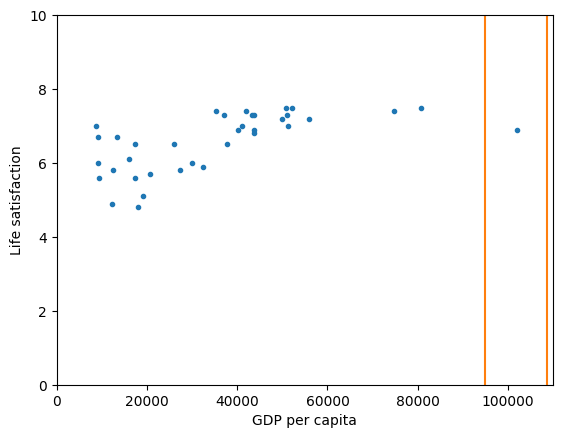

In [0]:
plt.plot(x,y,".")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.xlim(0, xlim)
plt.ylim(0,10)

from sklearn import preprocessing
from sklearn import pipeline


pipeline_reg = MyPipeline(degree=30)

pipeline_reg.fit(X, y) 
print("estimated coef:\n",pipeline_reg.coef_)
print("estimated intercept:\n",pipeline_reg.intercept_)

y_test_hat = pipeline_reg.predict(x_test[:,np.newaxis])

plt.plot(x_test,y_test_hat);

Cela ne fonctionne pas!  l'erreur se trouve dans `MyPipeline`. C'est une erreur très fréquente.  Le pire est que cette erreur ne se détecte pas à tous les coups: essayez avec `degree=3`, cela fonctionne quand même! 

***A vous:*** Corrigez $(3\heartsuit)$ cette erreur!  Aide: il faut distinguer deux cas dans la méthode `_data_augmentation`. 